# Power calculations for a machine learning regression model

In a previous [post](http://www.erikdrysdale.com/threshold_and_power) I discussed how to calibrate a machine learning (ML) model for a binary classification task in the context of a statistical trial. The classical ML pipeline is to train and tune a model on a training and validation set, and then make predictions (only once) on a test set to get an "unbiased" estimate of a performance metric(s) that this model will have.[[^1]] A statistical trial represents a further iteration on the ML pipeline: collecting data prospectively to "confirm" that the model works as well as you expect.

For binary classifiers there were two statistical goals in preparing for a prospective trial: 1) using the test set to pick a threshold that will give the algorithm some pre-specified performance bounds, and 2) determining a sample size necessary to reject a null hypothesis of a worst-case performance on the prospective dataset. The first task was made easy by the fact that the desired performance level (e.g. sensitivity of 90%) could be chosen *a priori*, and the threshold would adjust *ex post* to match this expectation. In other words: the null hypothesis was known in advance, but the threshold was a random variable. 

The regression case is more complicated because the desired performance cannot be chosen in advance: the result is what it is. However we could specify a null hypothesis in advance, and then obtain a p-value from the test set (e.g. a null of the [R2](https://en.wikipedia.org/wiki/Coefficient_of_determination) less than 10%). Why would we want to be cautious about running a prospective trial only for a ML regression algorithm that was statistically significant? The problem is that this would create a statistical significance [filter](http://www.erikdrysdale.com/winners_curse/), where conditional on success (i.e. rejection of null), the expected test set performance will be biased upwards. The estimated sample size needed for a such a trial will be an underestimate because the effect size will be overestimated.

Instead I recommend that the test set for a regression model be used to generate the hypothesis that will then be validated in a prospective trial. This approach has the advantage that the hypothesis and effect sizes will always be "unbiased" and allow for classic inferential techniques to work at the rate levels.

## (1) Conceptual approach

Consider a two-stage testing strategy to establish an upper-bound on the "true" mean of a Gaussian distribution. In the first stage, a sample is drawn, and the distribution of the sample mean is used to estimate the null hypothesis. In the second stage, a new sample is drawn, and the null from stage 1 is used to calculate a test statistic and a p-value is calculated. Assume the data is IID and comes from a normal with a known variance: $X_i \sim N(\mu, \sigma^2)$.

$$
\begin{align*}
&\text{Step 1: Establish null} \\
\hat{\mu}_0 &= \hat\mu_1 + k \sqrt{\sigma / n_1} \\
H_0&: \mu_0 \geq \hat{\mu}_0 \\
H_A&: \mu_0 < \hat{\mu}_0 \\
&\text{Step 2: Test on second sample} \\
s_2 &= \frac{\hat\mu_2 - \hat\mu_0}{\sqrt{\sigma^2 / n_2}} \\
\text{Reject }H_0&: s_2 < \Phi_{s_2}^{-1}(\alpha) = t_\alpha
\end{align*}
$$

In the first stage, the null is the point estimate of the mean plus $k$ standard deviations above it. The choice of $k$ determines how much slack we want to build into the testing in the second stage. The larger the $k$, the easier it is the reject the null, although the less information we have about the mean. Consider the distribution of $s_2$, which is the test statistic in the second stage of the procedure:

$$
\begin{align*}
s_2&= \frac{\hat\mu_2-[\hat\mu_1+k\sqrt{\sigma^2/n_1}]}{\sigma^2/n_2} \\
&= z_2 - \sqrt{n_2/n_1}(z_1 + k) \\
z_i &= \frac{\hat\mu_i - \mu}{\sqrt{\sigma^2 / n_i}}
\end{align*}
$$

The unconditional distribution of the statistic can be seen to have a normal distribution:

$$
\begin{align*}
s_2&\sim N(-\sqrt{n_2/n_1}\cdot k, 1+n_2/n_1)
\end{align*}
$$

For a given $n_2$, as $n_1 \to \infty$, then the probability of rejecting the null, $P(s_2 < t_\alpha)$ approaches $\alpha$ since $s_2 \to N(0,1)$. For a given $n_1$, as $n_2 \to \infty$, then the probability of rejecting the null approaches $\Phi(k)$. However, we are likely more interested in the distribution of $s_2$ only when the null is false, and not when it is true. This distribution is more complex:

$$
\begin{align}
s_2 | \{\text{$H_0$ is false}\} &\sim \frac{\hat\mu_2-\hat\mu_0}{\sqrt{\sigma^2/n_2}} \hspace{1mm} \Big|\hspace{1mm} \hat\mu_0 > \mu \nonumber \\
&\sim z_2 - r\cdot z_1^k | z_1^k > 0 \label{eq:dist_cond} \\
z_1^k &= z_1 + k, \hspace{3mm} r = \sqrt{n_2/n_1} \nonumber
\end{align}
$$

The conditional test statistic in \eqref{eq:dist_cond} is equivalent to a weighted sum of a standard normal and a truncated normal distribution. How can we characterize this distribution? The first step is to define a bivariate normal distribution as a function of $z_2\sim N(0,1)$ and $z_1^k~\sim(k,1)$.

$$
\begin{align}
X&= z_2 - r\cdot Y \nonumber \\ 
Y&= z_1^k \nonumber\\
\begin{pmatrix} X \\ Y \end{pmatrix} &\sim \text{MVN}\Bigg[ \begin{pmatrix} -rk \\ k \end{pmatrix}, \begin{pmatrix} 1+r^2 & -r \\ -r & 1 \end{pmatrix} \Bigg] \label{eq:dist_MVN} \\
\rho &= \frac{-r}{\sqrt{1+r^2}} \nonumber
\end{align}
$$

That's all very interesting, but how does this help us? Luckily the distribution of a truncated bivariate normal distribution for one of the variables has been [characterized](https://link.springer.com/article/10.1007/BF02294652) already by *Arnold et. al*. After working out some of the math, the density function of \eqref{eq:dist_MVN} conditional on $Y > 0$ or $Y<0$ can be written as follows:

$$
\begin{align*}
f_X(x) &= \frac{1}{\Phi(s\cdot k)} \cdot \frac{1}{\sqrt{1+r^2}} \cdot \phi\Bigg(\frac{x+rk}{\sqrt{1+r^2}} \Bigg) \cdot \Phi\Bigg(-(s\cdot r)\cdot \frac{x+rk}{\sqrt{1+r^2}} + \sqrt{1+r^2}\cdot (s\cdot k) \Bigg) \\
s &= \begin{cases}
+1 &\text{ if } \text{$H_0$ is false, } \hspace{2mm} (Y>0) \\
-1 &\text{ if } \text{$H_0$ is true}  \hspace{2mm} (Y<0)
\end{cases} \\
f_W(w) &= \frac{1}{\Phi(k)} \cdot \frac{1}{\sigma_W} \cdot \phi(w) \cdot  \Phi(a + b\cdot w), \hspace{3mm} w=\frac{x+rk}{\sqrt{1+r^2}}
\end{align*}
$$

Next, we can use Owen's classic [paper](https://www.tandfonline.com/doi/abs/10.1080/03610918008812164) shows that we can [use](https://mathoverflow.net/questions/283928/closed-form-solution-for-an-integral-involving-the-p-d-f-and-c-d-f-of-a-n0-1) the CDF of a bivariate normal to calculate the CDF of $W$:

$$
\begin{align*}
F_W(w) &= \frac{1}{\Phi(s\cdot k)} \int_{-\infty}^w \frac{1}{\sigma_W} \cdot \phi(u) \cdot  \Phi(a + b\cdot u) du \\
&= \frac{1}{\Phi(s\cdot k)}  \text{BVN}\Big( X_1 \leq \frac{a}{\sqrt{1+b^2}}, X_2 \leq w, \rho=-b/\sqrt{1+b^2} \Big) \\
F_X(x) &= F_W\big((x+rk) / \sqrt{1+r^2}\big) \label{eq:cdf_X}
\end{align*}
$$

The first code block below shows how to calculate the CDF of \eqref{eq:dist_cond} using \eqref{eq:cdf_X}.

In [191]:
import numpy as np
from scipy.stats import norm
from scipy.stats import multivariate_normal as MVN
import pandas as pd
import plotnine
from plotnine import *
from scipy.optimize import minimize_scalar

class cond_dist():
    def __init__(self, k, n1, n2, null=False):
        self.s = +1
        if null is True:
            self.s = -1
        self.k, self.n1, self.n2 = k, n1, n2
        self.r = np.sqrt(n2 / n1)
    
    def cdf_w(self, w):
        a = np.sqrt(1+self.r**2) * self.k * self.s
        b = -self.r * self.s
        rho = -b/np.sqrt(1+b**2)
        Sigma = np.array([[1,rho],[rho,1]])
        dist_MVN = MVN(mean=np.repeat(0,2),cov=Sigma)
        x1 = a / np.sqrt(1+b**2)
        if isinstance(w, float):
            X = [x1, w]
        else:
            X = np.c_[np.repeat(x1,len(w)), w]
        pval = dist_MVN.cdf(X)
        return pval
    
    def cdf_x(self, x):
        const = 1 / norm.cdf(self.s * self.k)
        w = (x + self.r * self.k) / np.sqrt(1+self.r**2)
        pval = self.cdf_w(w) * const
        return pval
    
    def quantile(self, p):
        res = minimize_scalar(fun=lambda x: (self.cdf_x(x)-p)**2, method='brent').x
        return res

0.049999999797101194
0.5021134995770294


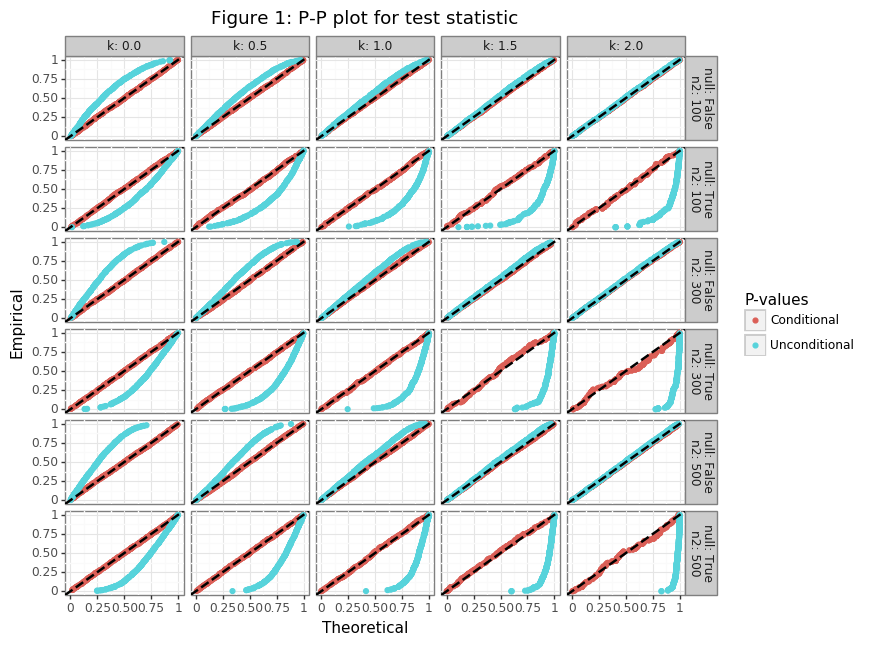

<ggplot: (-9223371875252696704)>

In [183]:
seed = 1234
n1 = 100
sig2 = 2
mu = 3
nsim = 5000

n2_seq = [100, 300, 500]
k_seq = list(np.arange(0,2.5,0.5))

np.random.seed(seed)
holder = []
for k in k_seq:
    for n2 in n2_seq:
        c = k * np.sqrt(sig2/n1)
        # Draw samples for two-stages
        x1 = mu + np.sqrt(sig2)*np.random.randn(n1, nsim)
        x2 = mu + np.sqrt(sig2)*np.random.randn(n2, nsim)
        xbar1, xbar2 = x1.mean(0), x2.mean(0)
        null_mu = xbar1 + c
        s2 = (xbar2 - null_mu)/np.sqrt(sig2/n2)
        # Calculate the p-values
        pval_h0false = cond_dist(k=k, n1=n1, n2=n2, null=False).cdf_x(s2)
        pval_h0true = cond_dist(k=k, n1=n1, n2=n2, null=True).cdf_x(s2)
        pval_uncond = norm(loc=-np.sqrt(n2/n1)*k,scale=np.sqrt(1+n2/n1)).cdf(s2)
        tmp = pd.DataFrame({'s2':s2,'mu0':null_mu,'n2':n2,'k':k,
                            'h0_false':pval_h0false, 'h0_true':pval_h0true,'pval_uncond':pval_uncond})
        holder.append(tmp)
        del tmp
df_res = pd.concat(holder).assign(null=lambda x: np.where(x.mu0 > mu, False, True))
cn_gg = ['null','n2','k']
df_res = df_res.sort_values(cn_gg+['s2']).reset_index(None,True)
df_res = df_res.assign(idx=df_res.groupby(cn_gg).cumcount())
df_res.idx = df_res.groupby(cn_gg).apply(lambda x: x.idx/x.idx.max()).values
# Compare the conditional distribution
df_res = df_res.assign(pval_cond=lambda x: np.where(x.null==False,x.h0_false,x.h0_true))
df_res_long = df_res.melt(cn_gg+['idx'],['pval_cond','pval_uncond'],'tt')

# Make a pp-plot
tmp = df_res_long.groupby(cn_gg+['tt']).sample(n=250, random_state=seed,replace=True)
plotnine.options.figure_size = (8, 7)
gg_pp = (ggplot(tmp, aes(x='value',y='idx',color='tt')) + theme_bw() + 
         geom_point() + labs(x='Theoretical',y='Empirical') + 
         ggtitle('Figure 1: P-P plot for test statistic') + 
         facet_grid('n2+null~k',labeller=label_both) + 
         scale_color_discrete(name='P-values',labels=['Conditional','Unconditional']) + 
         geom_abline(slope=1,intercept=0,linetype='--',color='black',size=1))
gg_pp

Figure 1 shows that the CDF for the conditional distribution in \eqref{eq:cdf_X} accurately captures the distribution of the test statistic when the null is both false and true. When the null is false ($z_1^k > 0)$, for larger values of $k$, the unconditonal distribution of $s_2$ is a close approximation. This result makes sense since when the null hypothesis is set many standard deviations above the point estimate, the null will be false for almost all realizations so the conditioning event excludes very few samples. 

In classical statistics we pick a critical value to reject the null such that when the null is true, then rejection event happens at most $\alpha$ percent of the time. We can use \eqref{eq:cdf_X} to find the $\alpha-$quantile of the distribution when the null is true so that we reject it at most $a$-percent of the time:

$$
\begin{align*}
F^{-1}_W(\alpha) &= \sup_w: \{ F_W(w)\leq \alpha \}
\end{align*}
$$

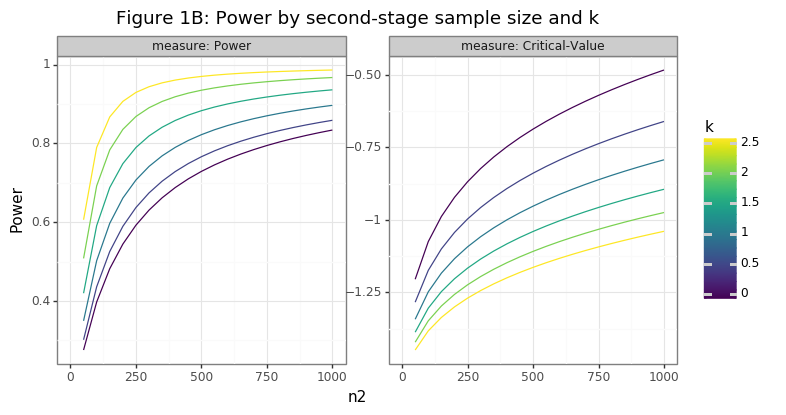

<ggplot: (-9223371875242511664)>

In [254]:
np.random.seed(seed)
# Calculate power for a range of n2's/k's
alpha = 0.05
n2_seq = np.arange(50,1001, 50)
k_seq = np.arange(0.0, 2.51, 0.50)
holder = []
for k in k_seq:
    for n2 in n2_seq:
        dd_true = cond_dist(k=k, n1=n1, n2=n2, null=True)
        dd_false = cond_dist(k=k, n1=n1, n2=n2, null=False)
        crit = dd_true.quantile(alpha)
        power_theory = dd_false.cdf_x(crit)
        # --- simulation --- #
        c = k * np.sqrt(sig2/n1)
        # Draw samples for two-stages
        x1 = mu + np.sqrt(sig2)*np.random.randn(n1, nsim)
        x2 = mu + np.sqrt(sig2)*np.random.randn(n2, nsim)
        xbar1, xbar2 = x1.mean(0), x2.mean(0)
        null_mu = xbar1 + c
        s2 = (xbar2 - null_mu)/np.sqrt(sig2/n2)
        power_emp = np.mean(s2[null_mu > mu] < crit)
        type1_emp = np.mean(s2[null_mu < mu] < crit)
        # ------------------ #
        tmp = pd.Series({'k':k,'n2':n2,'Critical-Value':crit,'Power':power_theory,
                         'emp_power':power_emp, 'emp_type1':type1_emp})
        holder.append(tmp)
        del tmp
df_power = pd.concat(holder,1).T
df_power_long = df_power.melt(['k','n2'],['Critical-Value','Power'],'measure')
df_power_long.measure = pd.Categorical(df_power_long.measure,['Power','Critical-Value'])

plotnine.options.figure_size = (8, 4)
gg_power = (ggplot(df_power_long,aes(x='n2',y='value',color='k',group='k')) + theme_bw() + 
            geom_line() + labs(x='n2',y='Power') + 
            facet_wrap('~measure',labeller=label_both,scales='free_y') + 
            ggtitle('Figure 1B: Power by second-stage sample size and k') + 
            theme(subplots_adjust={'wspace': 0.15}) + 
            scale_x_continuous(limits=[0,1001]))
gg_power

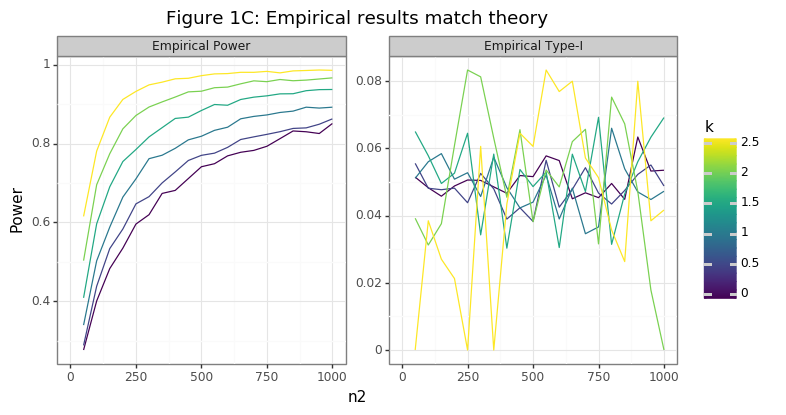

<ggplot: (-9223371875152263268)>

In [256]:
df_emp_long = df_power.melt(['k','n2'],['emp_power','emp_type1'],'tt')
df_emp_long.tt = df_emp_long.tt.map({'emp_power':'Empirical Power','emp_type1':'Empirical Type-I'})
plotnine.options.figure_size = (8, 4)
gg_emp = (ggplot(df_emp_long,aes(x='n2',y='value',color='k',group='k')) + theme_bw() + 
            geom_line() + labs(x='n2',y='Power') + facet_wrap('~tt',scales='free_y') + 
            ggtitle('Figure 1C: Empirical results match theory') + 
            theme(subplots_adjust={'wspace': 0.15}) + 
            scale_x_continuous(limits=[0,1001]))
gg_emp

## (2) Application to regression statistics

Imagine you have been given an imaging dataset and you have trained a CNN to count the number of cells in the image. On a held-out test set you observe a mean absolute error (MAE) of 5. You are now asked to answer the following two questions:

1. How confident am I that this CNN will an MAE of no more than 10 cells on new datasets?
2. If we were to collect a new test set, how many samples would I need to reject the null that the MAE$\geq$10?

Even though the [point estimate](https://en.wikipedia.org/wiki/Point_estimation) of the MAE in this case is less than 10 (i.e. 5), this realization could simply be the case by random chance alone. To get a range of uncertainty around the MAE point estimate, a [bootstrap](http://www.erikdrysdale.com/bca_python/) approach can be used. Even if the empirical confidence intervals (CIs) do no contain 10, one still needs to figure out how many samples would be needed on a new test set to reject the null. In this post I propose a three-stage algorithm to running a prospective trial for a regression model for a given statistic of interest (SoI), e.g. MAE, or mean square error (MSE):

0. Train and tune a ML regression model on a training/validation set
1. Obtain the point estimate and an upper bound of the SoI on the test set
2. Determine the standard error of the SoI with the bootstrap to estimate the standard deviation of the SoI ($\sigma_{S}$ )
3. Use $\sigma_{S}$ and the point estimate to calculate the sample size needed for a prospective dataset

Throughout this post we will use both the MAE and MSE as possible statistics of interest: $\text{MAE}(y,f(x))=|y-f_\theta(x)|$, where $y$ is the continuous label, $f_\theta$ is the fixed regression model from step 0, and $x$ are the features. 

[^1]: This assumes that the test set is representative of the data generating process. If new data comes from a different distribution then any performance metrics evaluated on a test set will not be generalizable.

## (1) Toy example

In practice one will never know the marginal distributions of $y$ and $x$, and certainly not their joint $y\sim g(x)$. However to do statistical simulations we will need to compare whether our inferences contain the "truth", which in the regression case is the risk of our loss function:

$$
\begin{align*}
R_{MAE}(\theta) = E_{y\sim g(x)}[\text{MAE}(y,f_\theta(x)]
\end{align*}
$$

If we knew the risk of the MAE, then we could already answer whether the regression model will, on average, have an MAE$\leq$10 for example. Suppose that the response and regression model are both linear, and the covariates are normal. When this is the case, the risk is very easy to calculate because the "residuals" of the model have a normal distribution.

$$
\begin{align*}
y &= x^T \theta^0 + u \\
u_i&\sim N(0,\sigma^2_u), \hspace{3mm} x \sim \text{MVN}(0,I) \\
e &= y - f_\theta(x) \\
&= x^T(\theta^0 - \theta) + u \\
&\sim N(0, \sigma^2_u + \| \theta^0 - \theta \|^2_2 )
\end{align*}
$$

The lower bound of the variance of the residual is the noise of the idiosyncratic error ($\sigma^2_u$). The risk for both the MSE or MAE can be easily calculated since $u$ has a known distribution.

$$
\begin{align}
R_{MSE}(\theta) &= E(u^2) = \sigma^2 + \| \theta^0 - \theta \|^2_2 \label{eq:risk_mse} \\
R_{MAE}(\theta) &= E( |u| ) = \sqrt{\sigma^2 + \| \theta^0 - \theta \|^2_2}\cdot\sqrt{2/\pi} \label{eq:risk_mae}
\end{align}
$$

Where the risk for the MAE comes from the [half-normal](https://en.wikipedia.org/wiki/Half-normal_distribution) distribution. The empirical estimate of the MAE and MSE is simply their sample average:

$$
\begin{align*}
\hat{\text{MSE}}(\theta) &= n^{-1} \sum_{i=1}^n [y_i - f_\theta(x_i)]^2 \\
\hat{\text{MAE}}(\theta) &= n^{-1} \sum_{i=1}^n |y_i - f_\theta(x_i)|
\end{align*}
$$

The the distribution of $\hat{\text{MAE}}$ is unknown, $\hat{\text{MSE}}$ can be shown to have a chi-squared distribution.

Let's now double check that the risk formulas in \eqref{eq:risk_mse} and \eqref{eq:risk_mae} lines up with our expectations. 



In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from arch.bootstrap import IIDBootstrap
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

import plotnine
from plotnine import *

In [ ]:
# We mu that mean(X1,..,Xn) ~ N(0, 1/n)
nsim = 1000
n_seq = np.arange(10,101,10)
np.random.seed(1234)
holder = []
for n in n_seq:
    holder.append(np.var([np.mean(np.random.randn(n)) for z in range(nsim)]))
sim1 = pd.DataFrame({'n':n_seq,'emp':holder,'theory':1/n_seq}).melt('n',None,'tt').assign(value=lambda x: np.sqrt(x.value))
plotnine.options.figure_size = (4,3)
(ggplot(sim1,aes(x='n',y='value',color='tt'))+theme_bw() + geom_point())


In [ ]:
np.random.seed(1234)

nsim = 1000
n_bs = 500
mu_var = []
for n in n_seq:
    holder = []
    for i in range(nsim):
        x = pd.Series(2*np.random.randn(n))
        vv_bs = x.sample(n*n_bs,replace=True).values.reshape([n,n_bs]).mean(0).var()
        holder.append(vv_bs)
    mu_var.append(np.mean(holder))
    
sim1 = pd.DataFrame({'n':n_seq,'emp':mu_var,'theory':4/n_seq}).melt('n',None,'tt').assign(value=lambda x: np.sqrt(x.value))
plotnine.options.figure_size = (4,3)
(ggplot(sim1,aes(x='n',y='value',color='tt'))+theme_bw() + geom_point())


$sqrt(sig2/100) == 0.2$

$sqrt(n) * 0.2 = sig$

When the distribution is actually normal, the variance of the bootstrap matches the variance of the statistic, and that $n$. 

Does the bootstrap distribution of the MSE have a normal dist?


In [ ]:
def dgp_yX(n,p,b0=1):
    X = np.random.randn(n,p)
    bvec = np.repeat(b0, p)
    eta = X.dot(bvec)
    e = np.random.randn(n)
    y = eta + e
    return y, X

n = 100
nsim = 10
n_bs = 500

for i in range(nsim):
    # Draw some data
    y, X = dgp_yX(n=int(2*n),p=5,b0=0.5)
    ytrain, Xtrain = y[:n], X[:n]
    ytest, Xtest = y[n:], X[n:]
    mdl = LinearRegression().fit(X=Xtrain,y=ytrain)
    eta_test = mdl.predict(Xtest)
    eta_boot = pd.Series(eta_test).sample(n*n_bs,replace=True)
    y_boot = ytest[eta_boot.index].reshape([n,n_bs])
    eta_boot = eta_boot.values.reshape([n,n_bs])
    mse_point = MSE(ytest, eta_test)
    mae_point = MAE(ytest, eta_test)
    mse_boot = MSE(y_boot, eta_boot,multioutput='raw_values')
    mae_boot = MAE(y_boot, eta_boot,multioutput='raw_values')
# r20 = r2_bs(ytest, Xtest, mdl)

In [ ]:
print(np.mean(mse_boot < mse_point + mse_boot.std()*norm.ppf(0.9)))
print(np.mean(mae_boot < mae_point + mae_boot.std()*norm.ppf(0.9)))

In [ ]:
# nboot = 1000
# nsim = 100
# k_seq = np.arange(10,100,10)
# # Calculate how fast the 95% bounds change with different n's
# storage = np.zeros(len(k_seq))
# for i, k in enumerate(k_seq):
#     print('k: %i' % k)
#     holder = np.zeros(nsim)
#     for j in range(nsim):
#         idx = np.random.choice(n,k,replace=False)
#         bs = IIDBootstrap(ytest[idx], Xtest[idx])
#         ub = bs.conf_int(r2_bs, nboot, method='bca', extra_kwargs={'m':mdl}, tail='two', size=0.95).flatten()[1]
#         del bs
#         holder[j] = ub
#     storage[i] = holder.mean()
#     print(storage[i])